# Programming Exercise 3
# 多类别分类和神经网络

## 简介

在本次练习中，您将实现一对多的逻辑回归和神经网络来识别手写数字。在开始编程练习之前，我们强烈建议您观看相关主题的视频讲座并完成复习问题。

本笔记本中包含了解决此任务所需的所有信息，您将在此笔记本中完成所有代码的实现。可以直接从此笔记本将作业提交到 Coursera 的评分系统（代码和说明如下所示）。

在开始练习之前，我们需要导入本次编程练习所需的所有库。在整个课程中，我们将使用 [`numpy`](http://www.numpy.org/) 进行所有数组和矩阵操作，使用 [`matplotlib`](https://matplotlib.org/) 进行绘图，使用 [`scipy`](https://docs.scipy.org/doc/scipy/reference/) 进行科学和数值计算函数和工具。您可以在 [github 仓库](https://github.com/dibgerge/ml-coursera-python-assignments) 的 README 文件中找到安装所需库的说明。


In [8]:
# 用于操作目录路径
import os

# Python 的科学和向量计算库
import numpy as np

# 绘图库
from matplotlib import pyplot

# scipy 中的优化模块
from scipy import optimize

# 用于加载 MATLAB mat 数据文件格式
from scipy.io import loadmat

# 为本次练习编写的库，提供额外的函数用于作业提交等
import utils

# 为本次练习定义的提交/评分对象
grader = utils.Grader()

# 告诉 matplotlib 将图嵌入到笔记本中
%matplotlib inline

## 提交和评分

完成每部分作业后，请务必将您的解决方案提交给评分系统。以下是本次练习中每部分得分的详细说明。

| 部分   | 内容                                 | 提交函数                             |  分数 
| :-     |:-                                    | :-                                    |  :-:    
| 1      | [正则化逻辑回归](#section1)          | [`lrCostFunction`](#lrCostFunction)   | 30     
| 2      | [一对多分类器训练](#section2)        | [`oneVsAll`](#oneVsAll)               | 20     
| 3      | [一对多分类器预测](#section3)        | [`predictOneVsAll`](#predictOneVsAll) | 20     
| 4      | [神经网络预测函数](#section4)        | [`predict`](#predict)                 | 30
|        | 总分                                |                                       | 100    

您可以多次提交您的解决方案，我们将只考虑最高分。

<div class="alert alert-block alert-warning">
在本笔记本的每个部分末尾，我们都有一个包含代码的单元格，用于将当前部分的解决方案提交给评分系统。执行该单元格以查看您到目前为止的得分。为了确保您的所有工作被正确提交，您必须至少执行这些单元格一次。每次更新提交的函数时，也必须重新执行这些单元格。
</div>


## 1 多类别分类

在本次练习中，您将使用逻辑回归和神经网络来识别手写数字（从 0 到 9）。自动手写数字识别在今天被广泛使用——从识别邮件信封上的邮政编码到识别支票上的金额。本次练习将向您展示如何使用您学到的方法来完成此分类任务。

在练习的第一部分，您将扩展之前实现的逻辑回归，并将其应用于一对多分类。

### 1.1 数据集

您将获得一个名为 `ex3data1.mat` 的数据集，其中包含 5000 个手写数字的训练样本（这是 [MNIST](http://yann.lecun.com/exdb/mnist) 手写数字数据集的一个子集）。`.mat` 格式表示数据已保存为原生的 Octave/MATLAB 矩阵格式，而不是像 csv 文件这样的文本（ASCII）格式。我们在这里使用 `.mat` 格式是因为这是 MATLAB 版本的作业中提供的数据集。幸运的是，Python 提供了使用 `scipy.io` 模块中的 `loadmat` 函数加载 MATLAB 原生格式的机制。此函数返回一个 Python 字典，其中的键包含 `.mat` 文件中的变量名。

`ex3data1.mat` 中有 5000 个训练样本，每个训练样本是一个 20 像素 x 20 像素的灰度图像，表示一个数字。每个像素由一个浮点数表示，指示该位置的灰度强度。20 x 20 的像素网格被“展开”为一个 400 维的向量。这些训练样本中的每一个都成为数据矩阵 `X` 中的一行。这使我们得到一个 5000 x 400 的矩阵 `X`，其中每一行都是一个手写数字图像的训练样本。

$$ X = \begin{bmatrix} - \: (x^{(1)})^T \: - \\ -\: (x^{(2)})^T \:- \\ \vdots \\ - \: (x^{(m)})^T \:-  \end{bmatrix} $$

训练集的第二部分是一个 5000 维的向量 `y`，其中包含训练集的标签。
我们从加载数据集开始本次练习。执行下面的代码单元，您不需要在这里编写任何代码。


In [9]:
# 20x20 输入的数字图像
input_layer_size  = 400

# 10 个标签，从 1 到 10（注意我们已将 "0" 映射为标签 10）
num_labels = 10

# 训练数据存储在数组 X, y 中
data = loadmat(os.path.join('Data', 'ex3data1.mat'))
X, y = data['X'], data['y'].ravel()

# 将数字 0 设置为 0，而不是在此数据集中映射的 10
# 这是因为该数据集在 MATLAB 中使用，而 MATLAB 中没有索引 0
y[y == 10] = 0

m = y.size


### 1.2 可视化数据

您将从可视化训练集的一个子集开始。在下面的代码单元中，代码随机选择 `X` 中的 100 行，并将这些行传递给 `displayData` 函数。该函数将每一行映射为一个 20 像素 x 20 像素的灰度图像，并将这些图像一起显示。我们在文件 `utils.py` 中提供了 `displayData` 函数。建议您查看代码以了解其工作原理。运行以下代码单元以可视化数据。

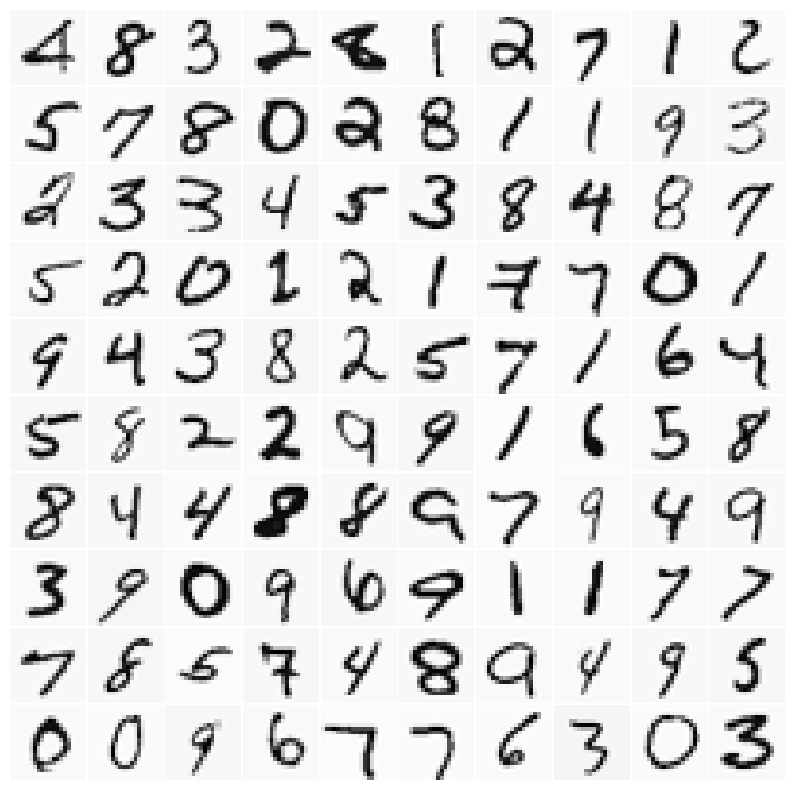

In [10]:
# 随机选择 100 个数据点进行显示
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

utils.displayData(sel)

### 1.3 向量化逻辑回归

您将使用多个一对多逻辑回归模型来构建一个多类别分类器。由于有 10 个类别，您需要训练 10 个独立的逻辑回归分类器。为了使训练高效，确保代码良好地向量化是非常重要的。在本节中，您将实现一个不使用任何 `for` 循环的向量化逻辑回归版本。您可以将上一练习中的代码作为本次练习的起点。

为了测试您的向量化逻辑回归，我们将使用以下单元中定义的自定义数据。

In [11]:
# 参数 theta 的测试值
theta_t = np.array([-2, -1, 1, 2], dtype=float)

# 输入的测试值
X_t = np.concatenate([np.ones((5, 1)), np.arange(1, 16).reshape(5, 3, order='F')/10.0], axis=1)

# 标签的测试值
y_t = np.array([1, 0, 1, 0, 1])

# 正则化参数的测试值
lambda_t = 3

<a id="section1"></a>
#### 1.3.1 向量化代价函数

我们将从编写代价函数的向量化版本开始。回想一下，在（未正则化的）逻辑回归中，代价函数为：

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)} \log \left( h_\theta\left( x^{(i)} \right) \right) - \left(1 - y^{(i)} \right) \log \left(1 - h_\theta \left( x^{(i)} \right) \right) \right] $$

为了计算求和中的每一项，我们需要为每个样本 $i$ 计算 $h_\theta(x^{(i)})$，其中 $h_\theta(x^{(i)}) = g(\theta^T x^{(i)})$，且 $g(z) = \frac{1}{1+e^{-z}}$ 是 sigmoid 函数。事实证明，我们可以通过矩阵乘法快速计算所有样本的值。让我们定义 $X$ 和 $\theta$ 为：

$$ X = \begin{bmatrix} - \left( x^{(1)} \right)^T - \\ - \left( x^{(2)} \right)^T - \\ \vdots \\ - \left( x^{(m)} \right)^T - \end{bmatrix} \qquad \text{和} \qquad \theta = \begin{bmatrix} \theta_0 \\ \theta_1 \\ \vdots \\ \theta_n \end{bmatrix} $$

然后，通过计算矩阵乘积 $X\theta$，我们得到：

$$ X\theta = \begin{bmatrix} - \left( x^{(1)} \right)^T\theta - \\ - \left( x^{(2)} \right)^T\theta - \\ \vdots \\ - \left( x^{(m)} \right)^T\theta - \end{bmatrix} = \begin{bmatrix} - \theta^T x^{(1)}  - \\ - \theta^T x^{(2)} - \\ \vdots \\ - \theta^T x^{(m)}  - \end{bmatrix} $$

在最后一个等式中，我们利用了 $a^Tb = b^Ta$（如果 $a$ 和 $b$ 是向量）。这使我们可以在一行代码中计算所有样本的 $\theta^T x^{(i)}$。

#### 1.3.2 向量化梯度

回想一下，（未正则化的）逻辑回归代价的梯度是一个向量，其中第 $j$ 个元素定义为：

$$ \frac{\partial J }{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left( \left( h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_j^{(i)} \right) $$

为了在数据集上向量化此操作，我们从显式写出所有 $\theta_j$ 的偏导数开始：

$$
\begin{align*}
\begin{bmatrix} 
\frac{\partial J}{\partial \theta_0} \\
\frac{\partial J}{\partial \theta_1} \\
\frac{\partial J}{\partial \theta_2} \\
\vdots \\
\frac{\partial J}{\partial \theta_n}
\end{bmatrix} = &
\frac{1}{m} \begin{bmatrix}
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_0^{(i)}\right) \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_1^{(i)}\right) \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_2^{(i)}\right) \\
\vdots \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_n^{(i)}\right) \\
\end{bmatrix} \\
= & \frac{1}{m} \sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x^{(i)}\right) \\
= & \frac{1}{m} X^T \left( h_\theta(x) - y\right)
\end{align*}
$$

其中：

$$  h_\theta(x) - y = 
\begin{bmatrix}
h_\theta\left(x^{(1)}\right) - y^{(1)} \\
h_\theta\left(x^{(2)}\right) - y^{(2)} \\
\vdots \\
h_\theta\left(x^{(m)}\right) - y^{(m)} 
\end{bmatrix} $$

注意，$x^{(i)}$ 是一个向量，而 $h_\theta\left(x^{(i)}\right) - y^{(i)}$ 是一个标量（单个数字）。
为了理解推导的最后一步，让 $\beta_i = (h_\theta\left(x^{(m)}\right) - y^{(m)})$，并观察到：

$$ \sum_i \beta_ix^{(i)} = \begin{bmatrix} 
| & | & & | \\
x^{(1)} & x^{(2)} & \cdots & x^{(m)} \\
| & | & & | 
\end{bmatrix}
\begin{bmatrix}
\beta_1 \\
\beta_2 \\
\vdots \\
\beta_m
\end{bmatrix} = x^T \beta
$$

其中值 $\beta_i = \left( h_\theta(x^{(i)} - y^{(i)} \right)$。

上述表达式允许我们在没有任何循环的情况下计算所有偏导数。如果您对线性代数感到熟悉，我们鼓励您通过矩阵乘法来验证向量化版本执行了相同的计算。

您的任务是编写未正则化的代价函数 `lrCostFunction`，它返回代价函数 $J(\theta)$ 和其梯度 $\frac{\partial J}{\partial \theta}$。您的实现应使用我们上面介绍的策略来计算 $\theta^T x^{(i)}$。您还应对代价函数的其余部分使用向量化方法。一个完全向量化的 `lrCostFunction` 不应包含任何循环。

<div class="alert alert-box alert-warning">
**调试提示：** 向量化代码有时可能会很棘手。一种常见的调试策略是使用 `numpy` 数组的 `shape` 属性打印出您正在处理的矩阵的大小。例如，给定一个大小为 $100 \times 20$（100 个样本，20 个特征）的数据矩阵 $X$ 和大小为 $20$ 的向量 $\theta$，您可以观察到 `np.dot(X, theta)` 是一个有效的乘法操作，而 `np.dot(theta, X)` 则不是。此外，如果您有代码的非向量化版本，您可以比较向量化代码和非向量化代码的输出，以确保它们产生相同的结果。
</div>
<a id="lrCostFunction"></a>


In [12]:
def lrCostFunction(theta, X, y, lambda_):
    """
    计算使用 theta 作为正则化逻辑回归参数的代价函数值
    以及代价函数相对于参数的梯度。
    
    参数
    ----------
    theta : array_like
        逻辑回归参数。一个形状为 (n, ) 的向量，其中 n 是特征数量（包括截距项）。  
    
    X : array_like
        数据集，形状为 (m x n)。m 是样本数量，n 是特征数量（包括截距项）。
    
    y : array_like
        数据标签。一个形状为 (m, ) 的向量。
    
    lambda_ : float
        正则化参数。 
    
    返回值
    -------
    J : float
        正则化代价函数的计算值。 
    
    grad : array_like
        一个形状为 (n, ) 的向量，表示代价函数相对于 theta 的梯度，
        在当前 theta 值下计算。
    
    说明
    ------------
    计算特定 theta 选择的代价。你需要将 J 设置为代价值。
    计算偏导数，并将 grad 设置为代价函数相对于 theta 中每个参数的偏导数。
    
    提示 1
    ------
    代价函数和梯度的计算可以高效地向量化。例如，考虑以下计算：
    
        sigmoid(X * theta)
    
    结果矩阵的每一行将包含该样本的预测值。你可以利用这一点来向量化代价函数和梯度的计算。
    
    提示 2
    ------
    在计算正则化代价函数的梯度时，有许多可能的向量化解决方案，但其中一种解决方案如下：
    
        grad = (逻辑回归的非正则化梯度)
        temp = theta 
        temp[0] = 0   # 因为对于 j = 0，我们不添加任何正则化项
        grad = grad + YOUR_CODE_HERE (使用 temp 变量)
    
    提示 3
    ------
    我们已经在 `utils.py` 文件中提供了 sigmoid 函数的实现。
    在笔记本的开头，我们将此文件作为模块导入。因此，要访问该文件中的 sigmoid 函数，你可以这样做：`utils.sigmoid(z)`。
    
    """
    # 初始化一些有用的值
    m = y.size

    # 类型安全：转为浮点
    theta = np.asarray(theta, dtype=float)
    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=float)

    # 初始化代价和梯度
    J = 0.0
    grad = np.zeros(theta.shape)

    ### --------------在此处填写您的代码-------------------- ###
    # 计算假设函数 h_theta(x)
    h = utils.sigmoid(X @ theta)

    # 计算代价函数 J（带正则化）
    # 注意：不惩罚 theta[0]
    J_no_reg = (-y @ np.log(h) - (1 - y) @ np.log(1 - h)) / m
    reg_term = (lambda_ / (2 * m)) * np.sum(theta[1:] ** 2)
    J = J_no_reg + reg_term

    # 计算梯度
    grad_no_reg = (X.T @ (h - y)) / m
    # 正则化梯度：theta[0] 不加正则项
    temp = theta.copy()
    temp[0] = 0
    grad = grad_no_reg + (lambda_ / m) * temp
    ### ---------------结束你的代码--------------------------- ###

    return float(J), grad


#### 1.3.3 向量化正则化逻辑回归

在实现了逻辑回归的向量化后，您现在将向代价函数添加正则化。回想一下，对于正则化的逻辑回归，代价函数定义为：

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)} \log \left(h_\theta\left(x^{(i)} \right)\right) - \left( 1 - y^{(i)} \right) \log\left(1 - h_\theta \left(x^{(i)} \right) \right) \right] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2 $$

注意，您不应该对用于偏置项的 $\theta_0$ 进行正则化。
相应地，正则化逻辑回归代价函数对 $\theta_j$ 的偏导数定义为：

$$
\begin{align*}
& \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta\left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)}  & \text{对于 } j = 0 \\
& \frac{\partial J(\theta)}{\partial \theta_0} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_\theta\left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m} \theta_j & \text{对于 } j  \ge 1
\end{align*}
$$

现在修改您在 [**上一单元格**](#lrCostFunction) 中的 `lrCostFunction` 代码以考虑正则化。同样，您的代码中不应包含任何循环。

<div class="alert alert-box alert-warning">
**python/numpy 提示：** 在实现正则化逻辑回归的向量化时，您可能经常只想对 $\theta$ 的某些元素进行求和和更新。在 `numpy` 中，您可以通过索引矩阵来访问和更新特定元素。例如，`A[:, 3:5] = B[:, 1:3]` 将用 B 的第 1 到 3 列替换 A 的第 3 到 5 列。要选择矩阵的列（或行）直到末尾，可以将冒号右侧留空。例如，`A[:, 2:]` 仅返回 A 的第 $3^{rd}$ 列到最后一列的元素。如果您将冒号左侧留空，则会选择矩阵的开头元素。例如，`A[:, :2]` 选择前两列，相当于 `A[:, 0:2]`。此外，您可以使用负索引从末尾索引数组。因此，`A[:, :-1]` 选择 A 的所有列，除了最后一列，而 `A[:, -5:]` 选择从倒数第 5 列到最后一列的元素。因此，您可以将其与求和和幂运算（$^{**}$）结合使用，以计算您感兴趣的元素的总和（例如，`np.sum(z[1:]**2)`）。在起始代码 `lrCostFunction` 中，我们还提供了另一种可能的方法来计算正则化梯度的提示。
</div>

完成实现后，您可以调用函数 `lrCostFunction` 来使用以下单元格测试您的解决方案：


In [13]:
J, grad = lrCostFunction(theta_t, X_t, y_t, lambda_t)

print('Cost         : {:.6f}'.format(J))
print('Expected cost: 2.534819')
print('-----------------------')
print('Gradients:')
print(' [{:.6f}, {:.6f}, {:.6f}, {:.6f}]'.format(*grad))
print('Expected gradients:')
print(' [0.146561, -0.548558, 0.724722, 1.398003]');

Cost         : 2.534819
Expected cost: 2.534819
-----------------------
Gradients:
 [0.146561, -0.548558, 0.724722, 1.398003]
Expected gradients:
 [0.146561, -0.548558, 0.724722, 1.398003]


完成练习的某一部分后，您可以通过首先将您修改的函数添加到提交对象中，然后将您的函数发送到 Coursera 进行评分来提交您的解决方案。

提交脚本会提示您输入登录电子邮件和提交令牌。您可以从作业的网页上获取提交令牌。您可以多次提交您的解决方案，我们只会考虑最高分。

*执行以下单元格以对本次练习第一部分的解决方案进行评分。*

In [14]:
# 将第 1 部分中实现的函数添加到 grader 对象中
grader[1] = lrCostFunction

# 将添加的函数发送到 Coursera 的评分系统以获取此部分的分数
grader.grade()


本地评分结果

                                  Part Name | Score    | Result
                                  --------- | -------- | --------
            Regularized Logistic Regression | 30       | 通过
             One-vs-All Classifier Training | 0        | 未通过
           One-vs-All Classifier Prediction | 0        | 未通过
         Neural Network Prediction Function | 0        | 未通过

总分: 30 / 100


<a id="section2"></a>
### 1.4 一对多分类

在本部分练习中，您将通过为数据集中的每个类别 $K$ 训练多个正则化逻辑回归分类器来实现一对多分类。在手写数字数据集中，$K = 10$，但您的代码应适用于任何 $K$ 值。

您现在应该完成下面函数 `oneVsAll` 的代码，以为每个类别训练一个分类器。特别是，您的代码应返回一个矩阵 $\theta \in \mathbb{R}^{K \times (N +1)}$，其中 $\theta$ 的每一行对应于一个类别的学习逻辑回归参数。您可以通过从 $0$ 到 $K-1$ 的“for”循环来实现，每个分类器独立训练。

请注意，此函数的 `y` 参数是一个从 0 到 9 的标签向量。在为类别 $k \in \{0, ..., K-1\}$ 训练分类器时，您需要一个 K 维的标签向量 $y$，其中 $y_j \in 0, 1$ 表示第 $j$ 个训练实例是否属于类别 $k$ $(y_j = 1)$，或者是否属于其他类别 $(y_j = 0)$。您可能会发现逻辑数组对此任务很有帮助。

此外，您将在本次练习中使用 scipy 的 `optimize.minimize`。
<a id="oneVsAll"></a>


In [15]:
def oneVsAll(X, y, num_labels, lambda_):
    """
    训练 num_labels 个逻辑回归分类器，并返回一个矩阵 all_theta，
    其中 all_theta 的第 i 行对应于标签 i 的分类器。

    参数
    ----------
    X : array_like
        输入数据集，形状为 (m x n)。m 是数据点的数量，
        n 是特征的数量。注意，我们不假设 X 中包含截距项（或偏置项），
        但我们在下面的代码中提供了添加偏置项到 X 的代码。
    
    y : array_like
        数据标签。一个形状为 (m, ) 的向量。
    
    num_labels : int
        可能的标签数量。
    
    lambda_ : float
        逻辑回归的正则化参数。
    
    返回值
    -------
    all_theta : array_like
        每个类别的逻辑回归训练参数。
        这是一个形状为 (K x n+1) 的矩阵，其中 K 是类别数量
        （即 `num_labels`），n 是不包括偏置的特征数量。
    
    说明
    ------------
    您需要完成以下代码，以训练 `num_labels` 个逻辑回归分类器，
    正则化参数为 `lambda_`。
    
    提示
    ----
    您可以使用 y == c 来获得一个由 1 和 0 组成的向量，
    该向量表示该类别的真实值是正确还是错误。
    
    注意
    ----
    对于本次作业，我们建议使用 `scipy.optimize.minimize(method='CG')`
    来优化代价函数。可以使用一个 for 循环
    （`for c in range(num_labels):`）来遍历不同的类别。
    
    示例代码
    ------------
    
        # 设置初始 theta
        initial_theta = np.zeros(n + 1)
      
        # 设置 minimize 的选项
        options = {'maxiter': 50}
    
        # 运行 minimize 以获得最优的 theta。此函数将返回一个类对象，
        # 其中 theta 在 `res.x` 中，代价在 `res.fun` 中
        res = optimize.minimize(lrCostFunction, 
                                initial_theta, 
                                (X, (y == c), lambda_), 
                                jac=True, 
                                method='TNC',
                                options=options) 
    """
    # 一些有用的变量
    m, n = X.shape
    
    # 您需要正确返回以下变量
    all_theta = np.zeros((num_labels, n + 1))

    # 在 X 数据矩阵中添加一列全为 1 的偏置项
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    # ====================== 在此处填写您的代码 ======================
    # 对每个类别训练一个二分类器
    for c in range(num_labels):
        # 构造当前类别的标签向量：属于类别 c 的样本标记为 1，其余为 0
        y_binary = (y == c).astype(int)
        
        # 初始化参数 theta
        initial_theta = np.zeros(n + 1)
        
        # 设置优化选项
        options = {'maxiter': 50}
        
        # 使用 scipy.optimize.minimize 进行优化
        res = optimize.minimize(lrCostFunction,
                                initial_theta,
                                args=(X, y_binary, lambda_),
                                jac=True,
                                method='TNC',
                                options=options)
        
        # 将优化得到的参数存入 all_theta
        all_theta[c, :] = res.x
    # ============================================================
    return all_theta


在您完成 `oneVsAll` 的代码后，以下单元将使用您的实现来训练一个多类别分类器。

In [16]:
lambda_ = 0.1
all_theta = oneVsAll(X, y, num_labels, lambda_)

C:\Users\33530\AppData\Local\Temp\ipykernel_26144\3858720602.py:85: OptimizeWarning: Unknown solver options: maxiter
  res = optimize.minimize(lrCostFunction,


*您现在应该提交您的解决方案。*

In [17]:
grader[2] = oneVsAll
grader.grade()


本地评分结果

                                  Part Name | Score    | Result
                                  --------- | -------- | --------
            Regularized Logistic Regression | 30       | 通过
             One-vs-All Classifier Training | 20       | 通过
           One-vs-All Classifier Prediction | 0        | 未通过
         Neural Network Prediction Function | 0        | 未通过

总分: 50 / 100


C:\Users\33530\AppData\Local\Temp\ipykernel_26144\3858720602.py:85: OptimizeWarning: Unknown solver options: maxiter
  res = optimize.minimize(lrCostFunction,


<a id="section3"></a>
#### 1.4.1 一对多预测

在训练您的一对多分类器后，您现在可以使用它来预测给定图像中包含的数字。对于每个输入，您应该计算它属于每个类别的“概率”，使用训练好的逻辑回归分类器。您的一对多预测函数将选择对应逻辑回归分类器输出最高概率的类别，并返回该类别标签（0, 1, ..., K-1）作为输入示例的预测结果。您现在应该完成函数 `predictOneVsAll` 中的代码，以使用一对多分类器进行预测。
<a id="predictOneVsAll"></a>

In [18]:
def predictOneVsAll(all_theta, X):
    """
    返回矩阵 X 中每个样本的预测向量。
    注意，X 包含按行排列的样本。all_theta 是一个矩阵，
    其中第 i 行是 i 类的训练逻辑回归 theta 向量。
    您应该将 p 设置为一个从 0 到 K-1 的值的向量
    （例如，p = [0, 2, 0, 1] 表示 4 个样本的预测类别分别为 0, 2, 0, 1）。
    
    参数
    ----------
    all_theta : array_like
        每个类别的逻辑回归训练参数。
        这是一个形状为 (K x n+1) 的矩阵，其中 K 是类别数量，
        n 是不包括偏置的特征数量。
    
    X : array_like
        要预测其标签的数据点。
        这是一个形状为 (m x n) 的矩阵，其中 m 是要预测的数据点数量，
        n 是不包括偏置项的特征数量。
        注意，我们在此函数中为 X 添加了偏置项。
    
    返回值
    -------
    p : array_like
        X 中每个数据点的预测结果。
        这是一个形状为 (m, ) 的向量。
    
    说明
    ------------
    完成以下代码以使用您学习的逻辑回归参数（one-vs-all）进行预测。
    您应该将 p 设置为一个预测向量（从 0 到 num_labels-1）。
    
    提示
    ----
    这段代码可以完全向量化，使用 numpy 的 argmax 函数。
    特别是，argmax 函数返回最大元素的索引，
    有关更多信息，请参阅 '?np.argmax' 或在线搜索。
    如果您的样本按行排列，那么您可以使用 np.argmax(A, axis=1)
    来获取每行的最大值的索引。
    """
    m = X.shape[0]
    num_labels = all_theta.shape[0]

    # 您需要正确返回以下变量
    p = np.zeros(m)

    # ====================== 在此处填写您的代码 ======================
    # 为 X 添加偏置项
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    
    # 计算每个样本属于每个类别的概率
    probs = utils.sigmoid(X @ all_theta.T)
    
    # 预测每个样本所属的类别（概率最高的类别）
    p = np.argmax(probs, axis=1)
    # ============================================================
    return p

完成后，调用您的 `predictOneVsAll` 函数，使用学习到的 $\theta$ 值。您应该会看到训练集的准确率约为 95.1%（即，它可以正确分类训练集中 95.1% 的样本）。

In [19]:
pred = predictOneVsAll(all_theta, X)
print('Training Set Accuracy: {:.2f}%'.format(np.mean(pred == y) * 100))

Training Set Accuracy: 96.46%


*您现在应该提交您的解决方案。*

In [20]:
grader[3] = predictOneVsAll
grader.grade()


本地评分结果

                                  Part Name | Score    | Result
                                  --------- | -------- | --------
            Regularized Logistic Regression | 30       | 通过
             One-vs-All Classifier Training | 20       | 通过
           One-vs-All Classifier Prediction | 20       | 通过
         Neural Network Prediction Function | 0        | 未通过

总分: 70 / 100


C:\Users\33530\AppData\Local\Temp\ipykernel_26144\3858720602.py:85: OptimizeWarning: Unknown solver options: maxiter
  res = optimize.minimize(lrCostFunction,


## 2 神经网络

在本次练习的上一部分中，您实现了多类别逻辑回归来识别手写数字。然而，逻辑回归无法形成更复杂的假设，因为它只是一个线性分类器（您可以为逻辑回归添加更多特征，例如多项式特征，但这可能会非常昂贵且耗时）。

在本次练习的这一部分中，您将实现一个神经网络来识别手写数字，使用与之前相同的训练集。神经网络能够表示形成非线性假设的复杂模型。本周，您将使用我们已经训练好的神经网络参数。您的目标是实现前向传播算法，以使用我们的权重进行预测。在下周的练习中，您将编写反向传播算法来学习神经网络参数。

我们首先重新加载并可视化包含 MNIST 手写数字的数据集（这与我们在本次练习的第一部分中所做的相同，我们在这里重新加载它以确保变量未被修改）。

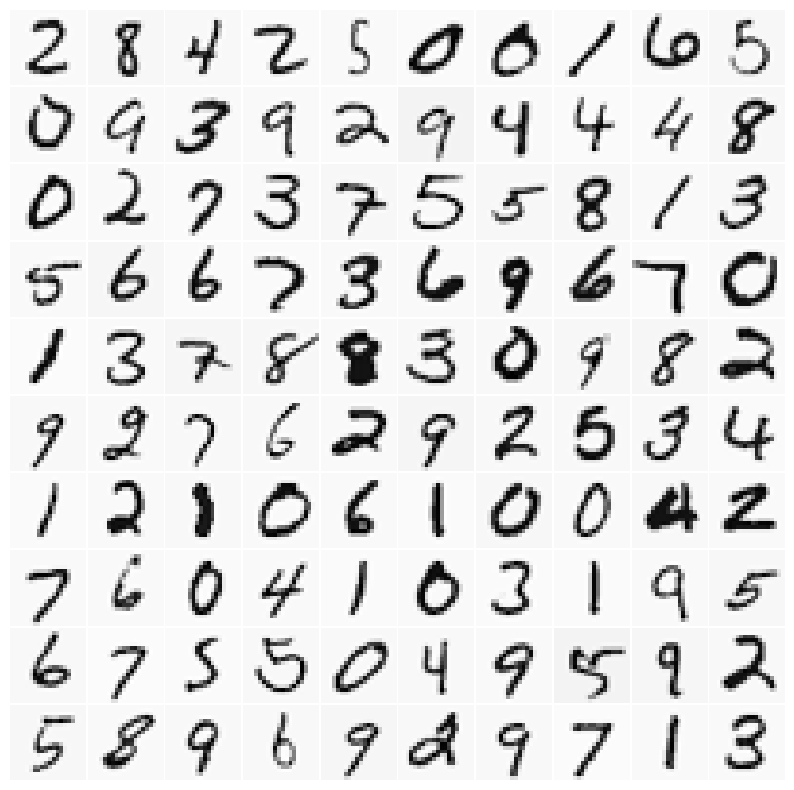

In [21]:
# 训练数据存储在数组 X, y 中
data = loadmat(os.path.join('Data', 'ex3data1.mat'))
X, y = data['X'], data['y'].ravel()

# 将数字 0 设置为 0，而不是在此数据集中映射的 10
# 这是因为该数据集在 MATLAB 中使用，而 MATLAB 中没有索引 0
y[y == 10] = 0

# 获取数据集中样本的数量
m = y.size

# 随机排列样本，用于一次可视化一张图片
indices = np.random.permutation(m)

# 随机选择 100 个数据点进行显示
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

utils.displayData(sel)



### 2.1 模型表示

我们的神经网络如下图所示。

![Neural network](Figures/neuralnetwork.png)

它有 3 层：输入层、隐藏层和输出层。回想一下，我们的输入是数字图像的像素值。由于图像大小为 20×20，这为我们提供了 400 个输入层单元（不包括始终输出 +1 的额外偏置单元）。与之前一样，训练数据将加载到变量 `X` 和 `y` 中。

我们已经为您提供了一组网络参数 ($\Theta^{(1)}$, $\Theta^{(2)}$)，这些参数已经由我们训练好。这些参数存储在 `ex3weights.mat` 文件中。以下单元格将这些参数加载到 `Theta1` 和 `Theta2` 中。参数的维度适用于一个具有 25 个隐藏层单元和 10 个输出单元（对应于 10 个数字类别）的神经网络。

In [22]:
# 设置您将在本次练习中使用的参数
input_layer_size  = 400  # 20x20 输入的数字图像
hidden_layer_size = 25   # 25 个隐藏单元
num_labels = 10          # 10 个标签，从 0 到 9

# 加载 .mat 文件，该文件返回一个字典
weights = loadmat(os.path.join('Data', 'ex3weights.mat'))

# 从字典中获取模型权重
# Theta1 的大小为 25 x 401
# Theta2 的大小为 10 x 26
Theta1, Theta2 = weights['Theta1'], weights['Theta2']

# 由于 MATLAB 索引的遗留问题，交换 Theta2 的第一列和最后一列，
# 因为权重文件 ex3weights.mat 是基于 MATLAB 索引保存的
Theta2 = np.roll(Theta2, 1, axis=0)

In [123]:
Theta1.shape

(25, 401)

<a id="section4"></a>
### 2.2 前向传播和预测

现在您将为神经网络实现前向传播。您需要完成函数 `predict` 中的代码以返回神经网络的预测结果。您应该实现前向传播计算，计算每个样本 $i$ 的 $h_\theta(x^{(i)})$ 并返回相关的预测结果。与一对多分类策略类似，神经网络的预测结果将是具有最大输出值 $\left( h_\theta(x) \right)_k$ 的标签。

<div class="alert alert-box alert-warning">
**实现注意事项：** 矩阵 $X$ 包含按行排列的样本。在完成函数 `predict` 中的代码时，您需要向矩阵中添加一列全为 1 的列。矩阵 `Theta1` 和 `Theta2` 包含每个单元的参数，按行排列。具体来说，`Theta1` 的第一行对应于第二层中的第一个隐藏单元。在使用 `numpy` 计算 $z^{(2)} = \theta^{(1)}a^{(1)}$ 时，请确保正确索引（如果需要，还需转置）$X$，以便获得 $a^{(l)}$ 作为一个一维向量。
</div>
<a id="predict"></a>

In [ ]:
def predict(Theta1, Theta2, X):
    """
    给定一个训练好的神经网络，预测输入的标签。
    
    参数
    ----------
    Theta1 : array_like
        神经网络第一层的权重。
        它的形状为 (第二隐藏层大小 x 输入大小)
    
    Theta2: array_like
        神经网络第二层的权重。 
        它的形状为 (输出层大小 x 第二隐藏层大小)
    
    X : array_like
        图像输入，形状为 (样本数量 x 图像维度)。
    
    返回值 
    ------
    p : array_like
        预测向量，包含每个样本的预测标签。
        它的长度等于样本数量。
    
    说明
    ------------
    完成以下代码以使用您学习的神经网络进行预测。
    您应该将 p 设置为一个包含 0 到 (num_labels-1) 之间标签的向量。
     
    提示
    ----
    这段代码可以完全向量化，使用 numpy 的 argmax 函数。
    特别是，argmax 函数返回最大元素的索引，
    有关更多信息，请参阅 '?np.argmax' 或在线搜索。
    如果您的样本按行排列，那么您可以使用 np.argmax(A, axis=1)
    来获取每行的最大值的索引。
    
    注意
    ----
    请记住，我们在 `utils.py` 文件中提供了 `sigmoid` 函数。
    您可以通过调用 `utils.sigmoid(z)` 使用此函数，
    其中可以将 `z` 替换为 sigmoid 所需的输入变量。
    """
    # 确保输入是二维的
    if X.ndim == 1:
        X = X[None]  # 提升为二维
    
    # 有用的变量
    m = X.shape[0]
    num_labels = Theta2.shape[0]

    # 您需要正确返回以下变量 
    p = np.zeros(X.shape[0])

    # ====================== 在此处填写您的代码 ======================
    # 为 X 添加偏置项
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    
    # 计算每个样本属于每个类别的概率
    probs = utils.sigmoid(X @ Theta1.T)
    
    # 为 probs 添加偏置项
    probs = np.concatenate([np.ones((m, 1)), probs], axis=1)
    
    # 计算每个样本属于每个类别的概率
    probs = utils.sigmoid(probs @ Theta2.T)
    
    # 预测每个样本所属的类别（概率最高的类别）
    p = np.argmax(probs, axis=1)
    # =============================================================
    return p


完成后，使用加载的 `Theta1` 和 `Theta2` 参数调用您的 predict 函数。您应该会看到准确率约为 97.5%。

In [125]:
pred = predict(Theta1, Theta2, X)
print('Training Set Accuracy: {:.1f}%'.format(np.mean(pred == y) * 100))

Training Set Accuracy: 10.0%


之后，我们将一次显示训练集中的一张图片，同时打印出神经网络对该图片的预测标签。

运行以下单元格以显示单个图片以及神经网络的预测结果。您可以多次运行该单元格以查看不同图片的预测结果。

Neural Network Prediction: 0.0


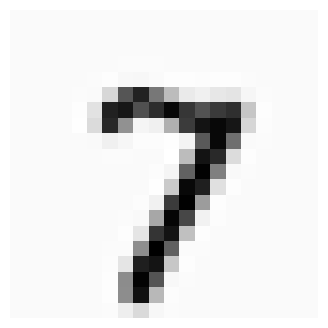

In [126]:
if indices.size > 0:
    i, indices = indices[0], indices[1:]
    utils.displayData(X[i, :], figsize=(4, 4))
    pred = predict(Theta1, Theta2, X[i, :])
    print('Neural Network Prediction: {}'.format(*pred))
else:
    print('No more images to display!')

*您现在应该提交您的解决方案。*

In [127]:
# grader[4] = predict
# grader.grade()

In [128]:
# Register all functions and run a single grade pass
grader[1] = lrCostFunction
grader[2] = oneVsAll
grader[3] = predictOneVsAll
grader[4] = predict
grader.grade()


本地评分结果

                                  Part Name | Score    | Result
                                  --------- | -------- | --------
            Regularized Logistic Regression | 0        | 未通过
             One-vs-All Classifier Training | 0        | 未通过
           One-vs-All Classifier Prediction | 0        | 未通过
         Neural Network Prediction Function | 0        | 未通过

总分: 0 / 100
